In [1]:
import xarray as xr
import pandas as pd
import altair as alt
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

import sys
sys.path.append('../../')
import sosutils

In [2]:
sos_ds = xr.open_dataset("example_dataset.nc")
sos_ds = sos_ds.drop_duplicates('time')

# Calculate wind gradient, temp gradient, and Ri

In [3]:
sos_ds['wind_gradient_3m_c'] = (['time'], sosutils.calculate_wind_gradient_for_height(sos_ds, 3).values)
sos_ds['wind_gradient_5m_c'] = (['time'], sosutils.calculate_wind_gradient_for_height(sos_ds, 5).values)
sos_ds['wind_gradient_10m_c'] = (['time'], sosutils.calculate_wind_gradient_for_height(sos_ds, 10).values)
sos_ds['wind_gradient_15m_c'] = (['time'], sosutils.calculate_wind_gradient_for_height(sos_ds, 15).values)

In [4]:
sos_ds['temp_gradient_3m_c'] = (['time'], sosutils.calculate_temperature_gradient_for_height(sos_ds, 3).values)
sos_ds['temp_gradient_5m_c'] = (['time'], sosutils.calculate_temperature_gradient_for_height(sos_ds, 5).values)
sos_ds['temp_gradient_10m_c'] = (['time'], sosutils.calculate_temperature_gradient_for_height(sos_ds, 10).values)
sos_ds['temp_gradient_15m_c'] = (['time'], sosutils.calculate_temperature_gradient_for_height(sos_ds, 15).values)

In [5]:
sos_ds['Ri_3m_c'] = (['time'], sosutils.calculate_richardson_number(sos_ds, 3))
sos_ds['Ri_5m_c'] = (['time'], sosutils.calculate_richardson_number(sos_ds, 5))
sos_ds['Ri_10m_c'] = (['time'], sosutils.calculate_richardson_number(sos_ds, 10))
sos_ds['Ri_15m_c'] = (['time'], sosutils.calculate_richardson_number(sos_ds, 15))

<AxesSubplot: ylabel='Count'>

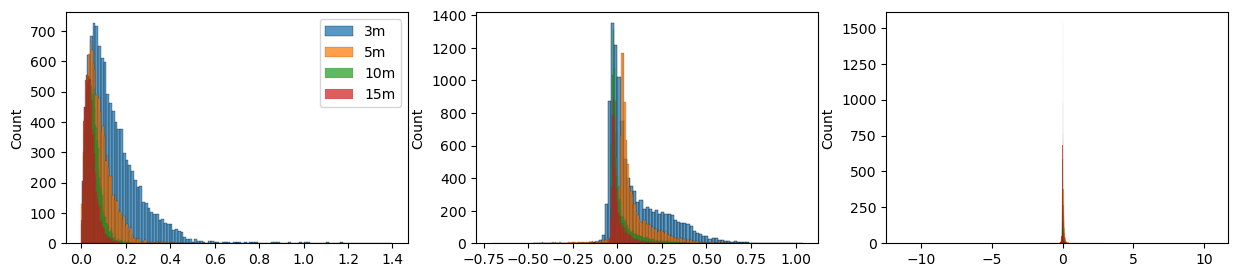

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
sns.histplot(sos_ds['wind_gradient_3m_c'], label='3m', ax=axes[0])
sns.histplot(sos_ds['wind_gradient_5m_c'], label='5m', ax=axes[0])
sns.histplot(sos_ds['wind_gradient_10m_c'], label='10m', ax=axes[0])
sns.histplot(sos_ds['wind_gradient_15m_c'], label='15m', ax=axes[0])
axes[0].legend()

sns.histplot(sos_ds['temp_gradient_3m_c'], label='3m', ax=axes[1])
sns.histplot(sos_ds['temp_gradient_5m_c'], label='5m', ax=axes[1])
sns.histplot(sos_ds['temp_gradient_10m_c'], label='10m', ax=axes[1])
sns.histplot(sos_ds['temp_gradient_15m_c'], label='15m', ax=axes[1])

sns.histplot(sos_ds['Ri_3m_c'], label='3m', ax=axes[2])
sns.histplot(sos_ds['Ri_5m_c'], label='5m', ax=axes[2])
sns.histplot(sos_ds['Ri_10m_c'], label='10m', ax=axes[2])
sns.histplot(sos_ds['Ri_15m_c'], label='15m', ax=axes[2])

# Show example of fitted log-linear curves

In [13]:
Z0 = 0.005
def log_linear_fn(z, a, b):
    return a*np.log(z/Z0) + b * (z/Z0)
def fit_log_linear(values, heights):
    if all([np.isfinite(v) for v in values]):
        [a,b], _ = curve_fit(log_linear_fn, heights, values)
        return a,b
    else:
        return np.nan, np.nan

In [14]:
i = 228
heights = [2,3,5,10,15,20]
u_values = [
    sos_ds.sel(time = sos_ds.time.values[i])['u_2m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['u_3m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['u_5m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['u_10m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['u_15m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['u_20m_c']
]
v_values = [
    sos_ds.sel(time = sos_ds.time.values[i])['v_2m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['v_3m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['v_5m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['v_10m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['v_15m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['v_20m_c']
]
u_params = fit_log_linear(u_values, heights)
v_params = fit_log_linear(v_values, heights)
u_fitted_values = [log_linear_fn(h, u_params[0], u_params[1]) for h in heights]
v_fitted_values = [log_linear_fn(h, v_params[0], v_params[1]) for h in heights]

spd_values = [
    sos_ds.sel(time = sos_ds.time.values[i])['spd_2m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['spd_3m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['spd_5m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['spd_10m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['spd_15m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['spd_20m_c']
]

dir_values = [
    sos_ds.sel(time = sos_ds.time.values[i])['dir_2m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['dir_3m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['dir_5m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['dir_10m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['dir_15m_c'],
    sos_ds.sel(time = sos_ds.time.values[i])['dir_20m_c']
]

In [15]:
from collections.abc import Iterable

def flatten(xs):
    for x in xs:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x

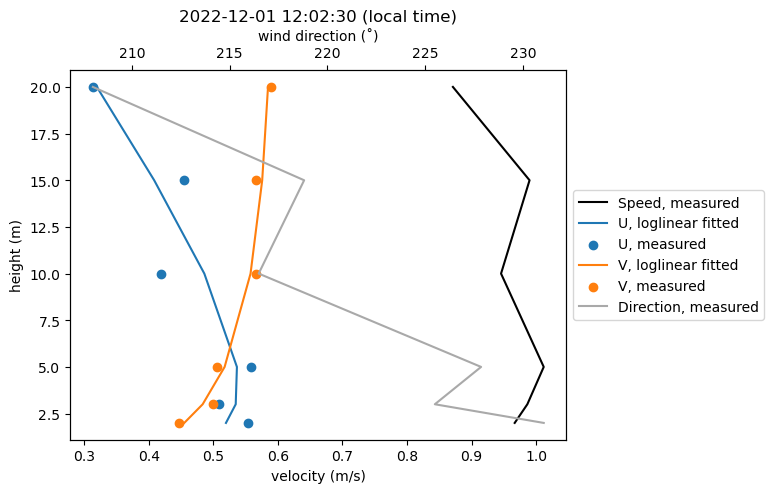

In [16]:
import datetime as dt
l1 = plt.plot(spd_values, heights, color='black', label='Speed, measured')

l2 = plt.plot(u_fitted_values, heights, color='tab:blue', label='U, loglinear fitted')
l3 = plt.scatter(u_values, heights, color='tab:blue', label='U, measured')

l4 = plt.plot(v_fitted_values, heights, color='tab:orange', label='V, loglinear fitted')
l5 = plt.scatter(v_values, heights, color='tab:orange', label='V, measured')

plt.xlabel("velocity (m/s)")
plt.ylabel("height (m)")

ax_twin = plt.gca().twiny()
l6 = ax_twin.plot(dir_values, heights, color='darkgrey', label='Direction, measured')
ax_twin.set_xlabel("wind direction (˚)")
plt.title(str(pd.to_datetime(sos_ds.time.values[i]) - dt.timedelta(hours=7)) + ' (local time)')

lns = list(flatten([l1,l2,l3,l4,l5,l6]))
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc='center left', bbox_to_anchor=(1, 0.5))